In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy
import pyarrow


import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

import patch
import kinematics

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import SSM.ssm as ssm
from SSM.ssm.util import find_permutation
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [4]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [5]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Fit HMM

In [6]:
def PlotLLS(hmm_lls):
    plt.plot(hmm_lls, label="EM")
    #plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()

color_names = ["windows blue","red","amber", "faded green","dusty purple","orange"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

def PlotStates(hmm_z, mouse_pos):
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
    times = pd.to_datetime(mouse_pos.index)
    numerical_times = (times - times[0]).total_seconds().values
    states_array = hmm_z.reshape(1, -1)
    
    fig, axs = plt.subplots(1, 1, figsize=(30, 3))
    extent = [numerical_times[0], numerical_times[-1], 0, 1]
    cax = axs.imshow(states_array, aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=extent)
    
    
    axs.set_xlabel('Time')
    axs.set_xticks(numerical_times[::len(numerical_times)//10])
    axs.set_xticklabels([time.strftime('%H:%M:%S') for time in times[::len(times)//10]], rotation=45, ha='right')
    
    axs.set_ylabel("States")
    axs.set_yticks([])
    
    '''   
    mouse_pos.Patch1_Forage.plot(ax = axs[1])
    mouse_pos.Patch2_Forage.plot(ax = axs[1])
    axs[1].set_xlim(start, end)
    axs[1].set_ylabel("Forage")
    axs[1].set_yticks([])
    axs[1].set_ylim(0, 1.1)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    
    mouse_pos.Patch1.plot(ax = axs[2])
    mouse_pos.Patch2.plot(ax = axs[2])
    axs[2].set_xlim(start, end)
    axs[2].set_ylabel("Visit")
    axs[2].set_yticks([])
    axs[2].set_ylim(0, 1.1)
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)'''
    
    plt.tight_layout()
    plt.show()


def PlotTransition(transition_mat):
    fig, axs = plt.subplots(1,1, figsize=(4, 4))
    sns.heatmap(transition_mat, cmap='YlGnBu', ax = axs, square = 'True', cbar = False)
    axs.set_title("Learned Transition Matrix")
    plt.show()  

def FitHMM(data, num_states, n_iters = 50):
    obs_dim = len(data[0])
    hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
    
    lls = hmm.fit(data, method="em", num_iters=n_iters, init_method="kmeans")
    states = hmm.most_likely_states(data)
    transition_mat = hmm.transitions.transition_matrix
    
    return hmm, states, transition_mat, lls

## Short Sessions

In [7]:
# Compute and Save Patch Information
'''for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)
                
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
            
    temp_df = mouse_pos.dropna(subset=['x', 'y'])
    first_valid_index = temp_df.index[0]
    last_valid_index = temp_df.index[-1]
    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]
    mouse_pos = kinematics.FixNan(mouse_pos)
        
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
            
    patch.AddKinematics(title, mouse_pos)
    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]
        
    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
    patch.AddWeight(mouse_pos, weight)
        
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
            
    patch.InPatch(mouse_pos, pellets_patch1, pellets_patch2)
    
    mouse_pos.to_parquet(title+'mousepos.parquet', engine='pyarrow')'''

"for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):\n    title = 'ShortSession'+str(i)\n    print(title)\n                \n    start, end = session.enter, session.exit\n    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)\n            \n    temp_df = mouse_pos.dropna(subset=['x', 'y'])\n    first_valid_index = temp_df.index[0]\n    last_valid_index = temp_df.index[-1]\n    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]\n    mouse_pos = kinematics.FixNan(mouse_pos)\n        \n    start, end = mouse_pos.index[0], mouse_pos.index[-1]\n            \n    patch.AddKinematics(title, mouse_pos)\n    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]\n        \n    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)\n    patch.AddWeight(mouse_pos, weight)\n        \n    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)\n    pellets_patch2 = api.load(root, exp0

### Fit the model using the first session

In [8]:
N = 6
feature = ['weight', 'smoothed_speed', 'smoothed_acceleration']

X, Y, SPEED, ACCE, VISIT1, VISIT2, FORAGE1, FORAGE2 = [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)]

ShortSession0


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

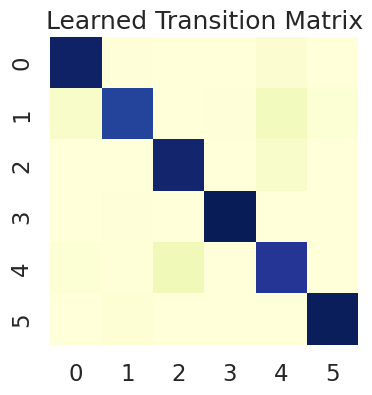

In [9]:
title = 'ShortSession'+str(0)
print(title)
mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        
obs = np.array(mouse_pos[feature])
hmm, states, transition_mat, lls = FitHMM(obs, num_states = N, n_iters = 50)
        
# PlotStates(states, mouse_pos)
PlotTransition(transition_mat)

### Fit the model to following sessions

ShortSession0


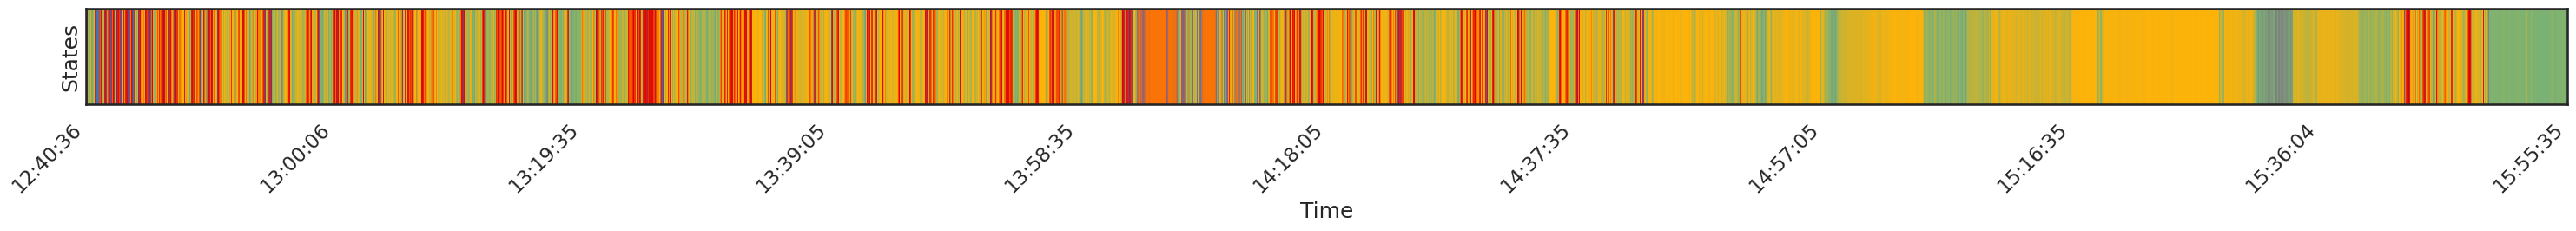

ShortSession1


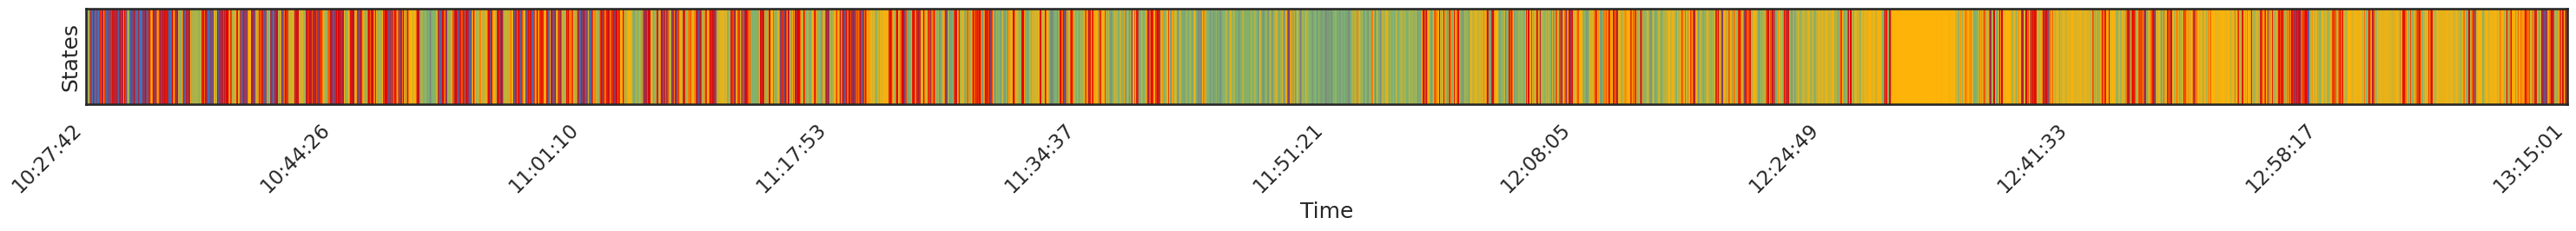

ShortSession2


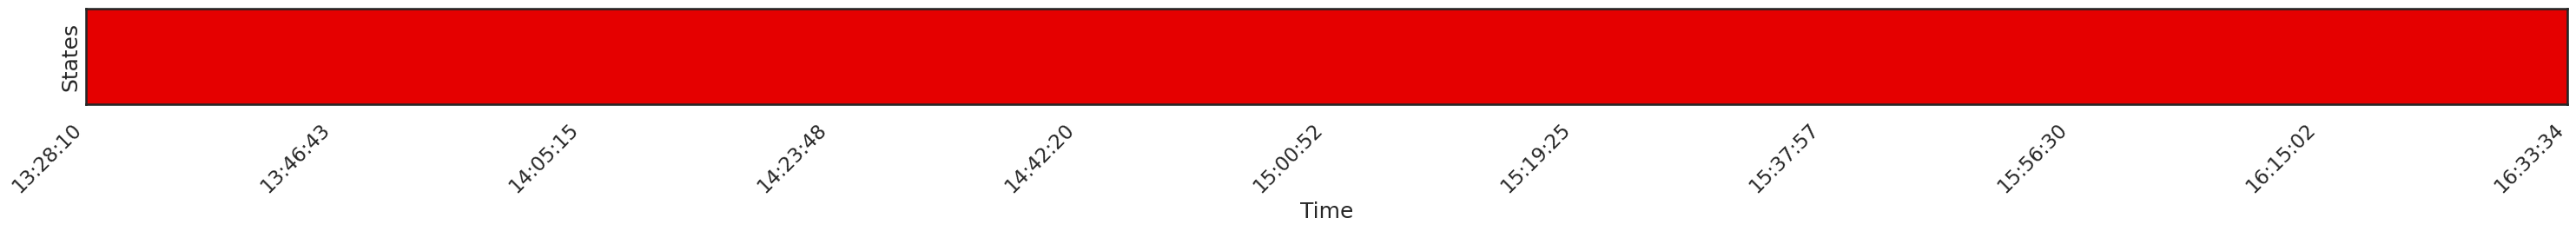

ShortSession3


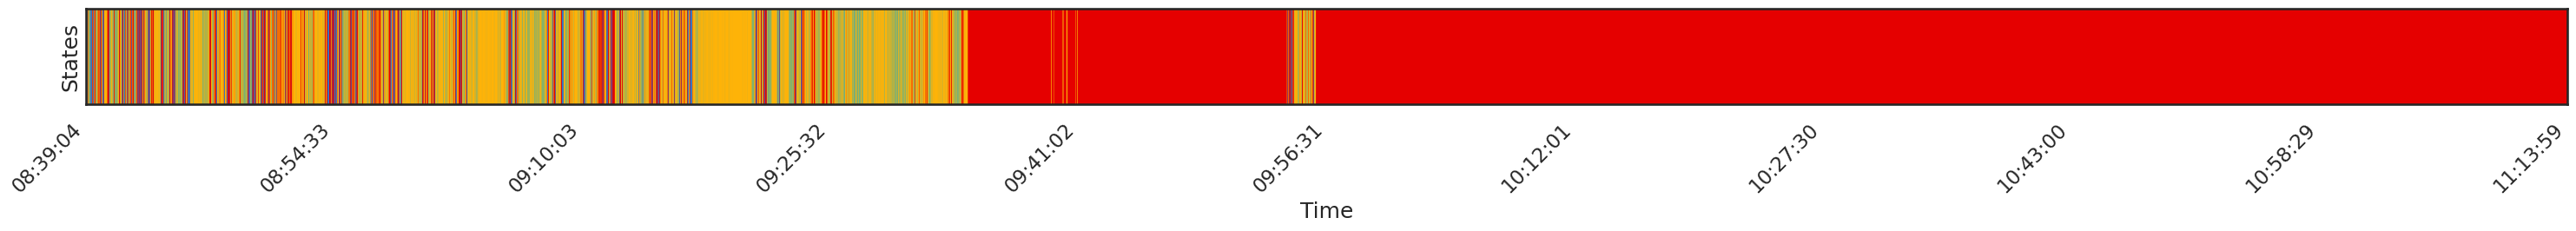

ShortSession4


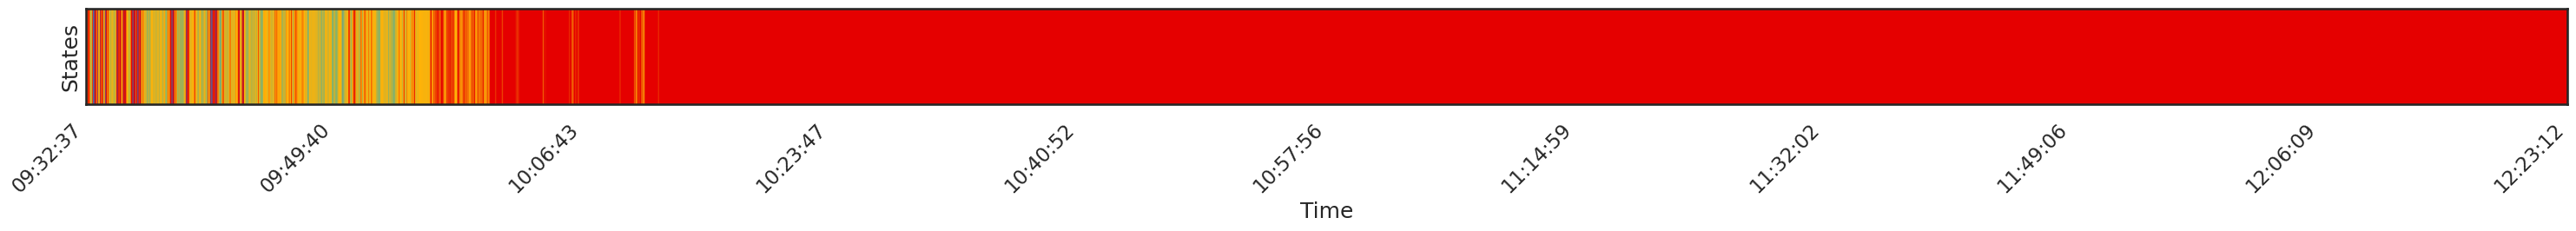

ShortSession5


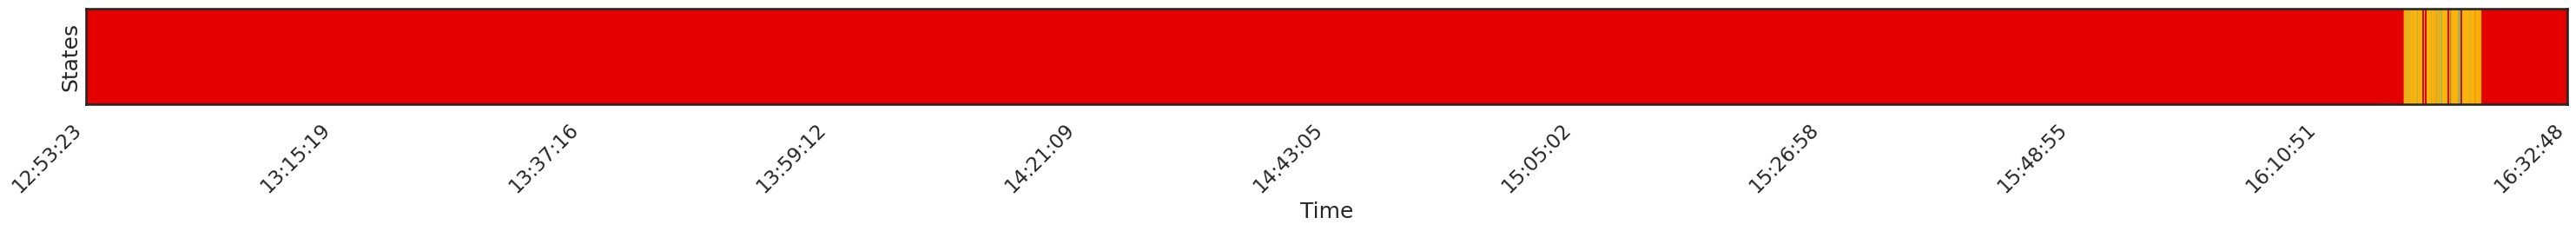

ShortSession6


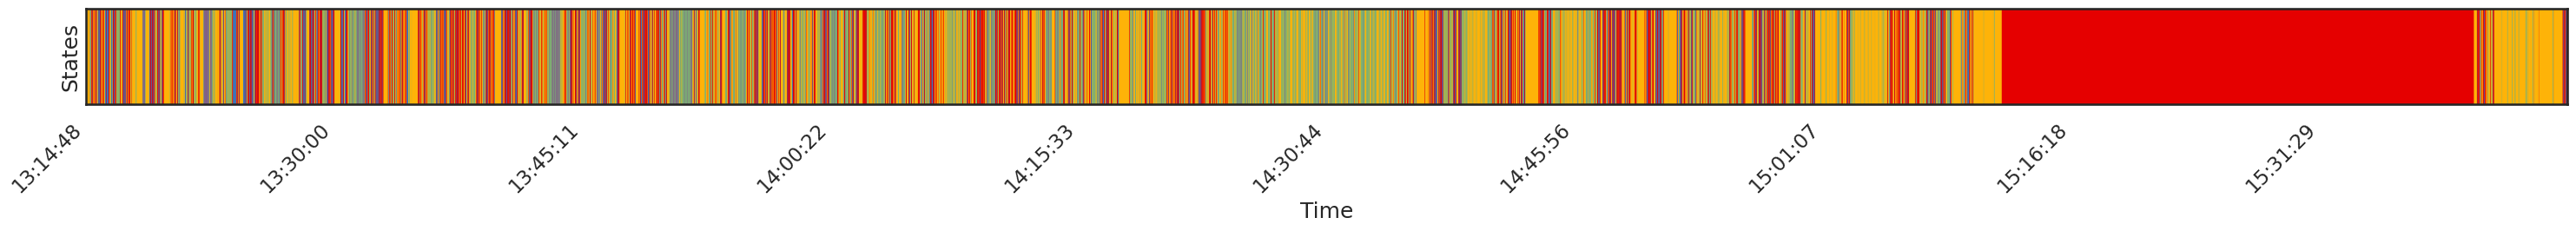

ShortSession7


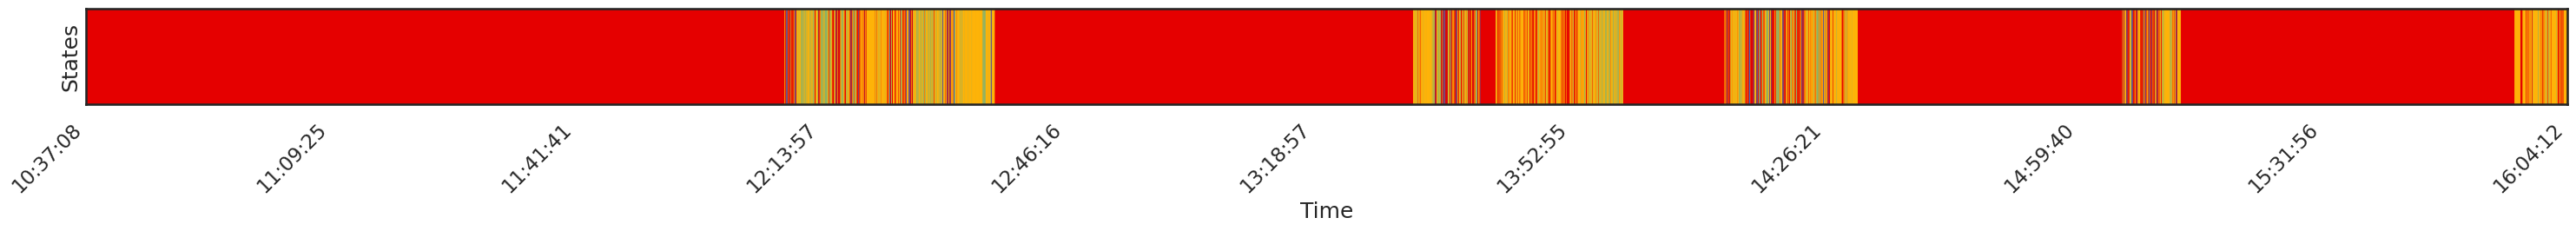

ShortSession8


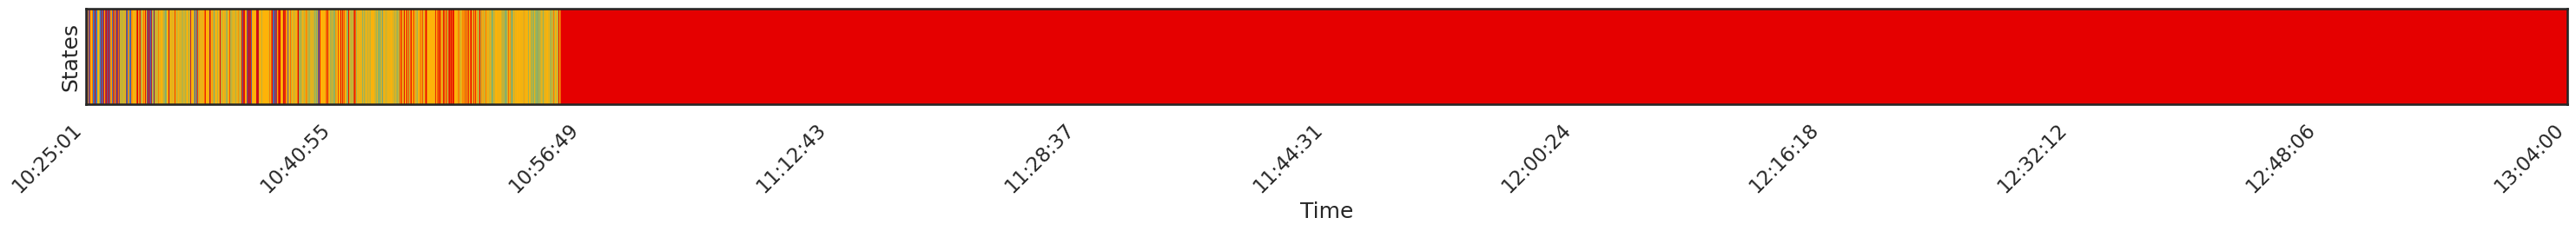

ShortSession9


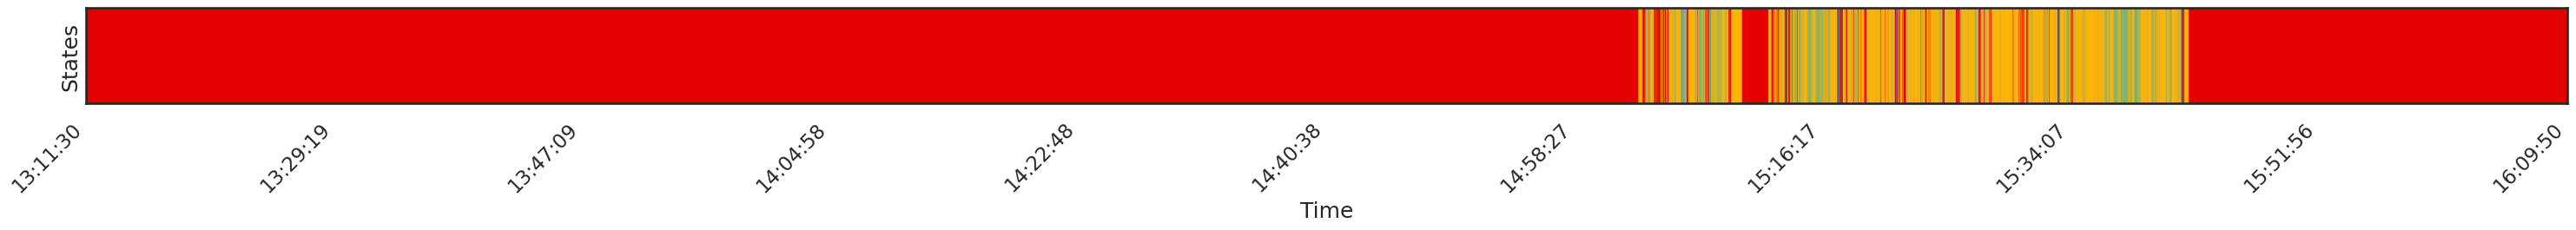

ShortSession10


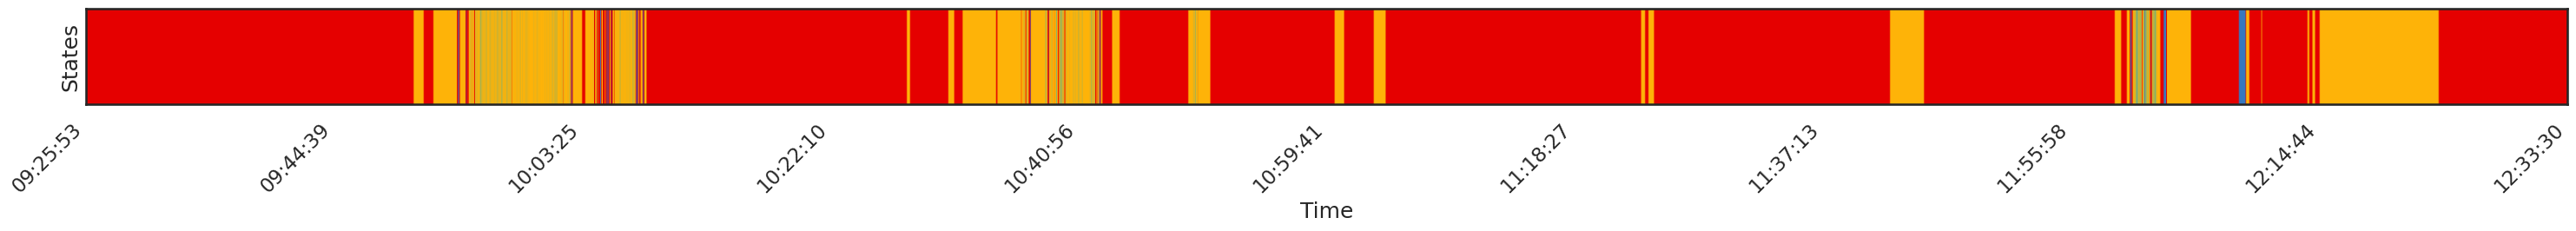

ShortSession11


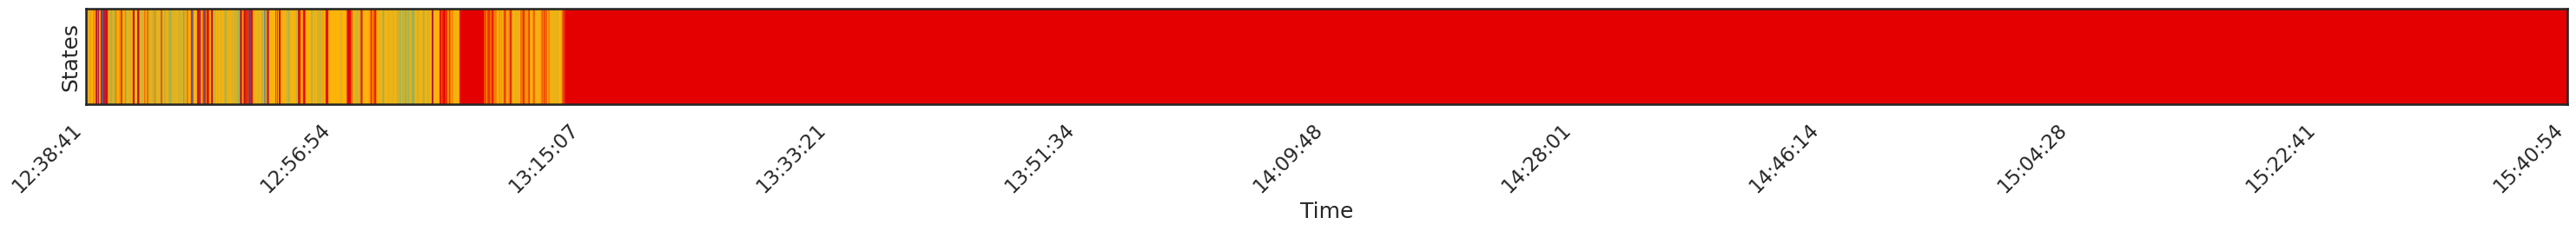

In [14]:
for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(j)
    print(title)
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        
    obs = np.array(mouse_pos[feature])
    states = hmm.most_likely_states(obs)
        
    PlotStates(states, mouse_pos)
    
    x = mouse_pos['smoothed_position_x']
    y = mouse_pos['smoothed_position_y']
    speed = mouse_pos['smoothed_speed']
    acceleration = mouse_pos['smoothed_acceleration']
    VisitPatch1 = mouse_pos['Patch1']
    VisitPatch2 = mouse_pos['Patch2']
    ForagePatch1 = mouse_pos['Patch1_Forage']
    ForagePatch2 = mouse_pos['Patch2_Forage']
    
    for i in range(N):
        X[i] = np.concatenate([X[i], x[states==i]])
        Y[i] = np.concatenate([Y[i], y[states==i]])
        SPEED[i] = np.concatenate([SPEED[i], speed[states==i]])
        ACCE[i] = np.concatenate([ACCE[i], acceleration[states == i]])
        VISIT1[i] = np.concatenate([VISIT1[i], VisitPatch1[states == i]])
        VISIT2[i] = np.concatenate([VISIT2[i], VisitPatch2[states == i]])
        FORAGE1[i] = np.concatenate([FORAGE1[i], ForagePatch1[states == i]])
        FORAGE2[i] = np.concatenate([FORAGE2[i], ForagePatch2[states == i]])

### Inteprete the states

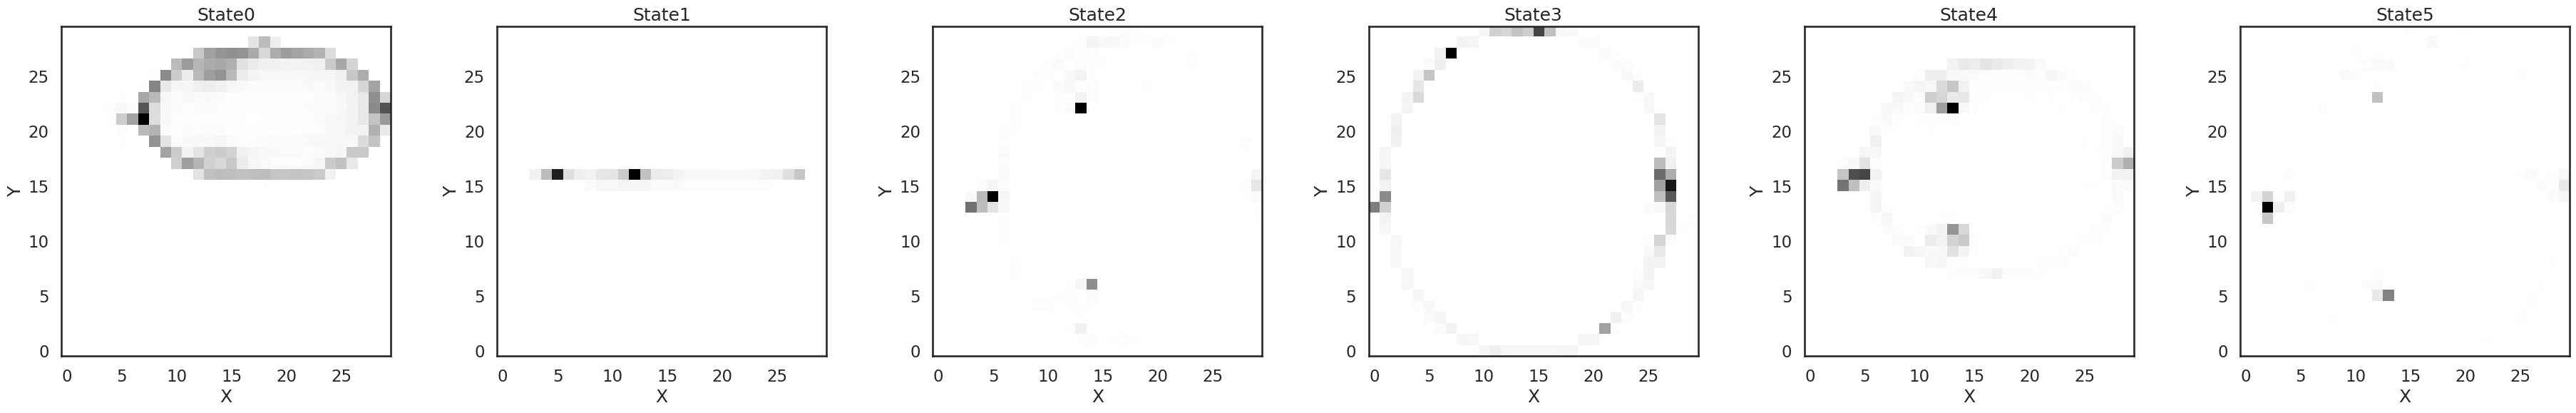

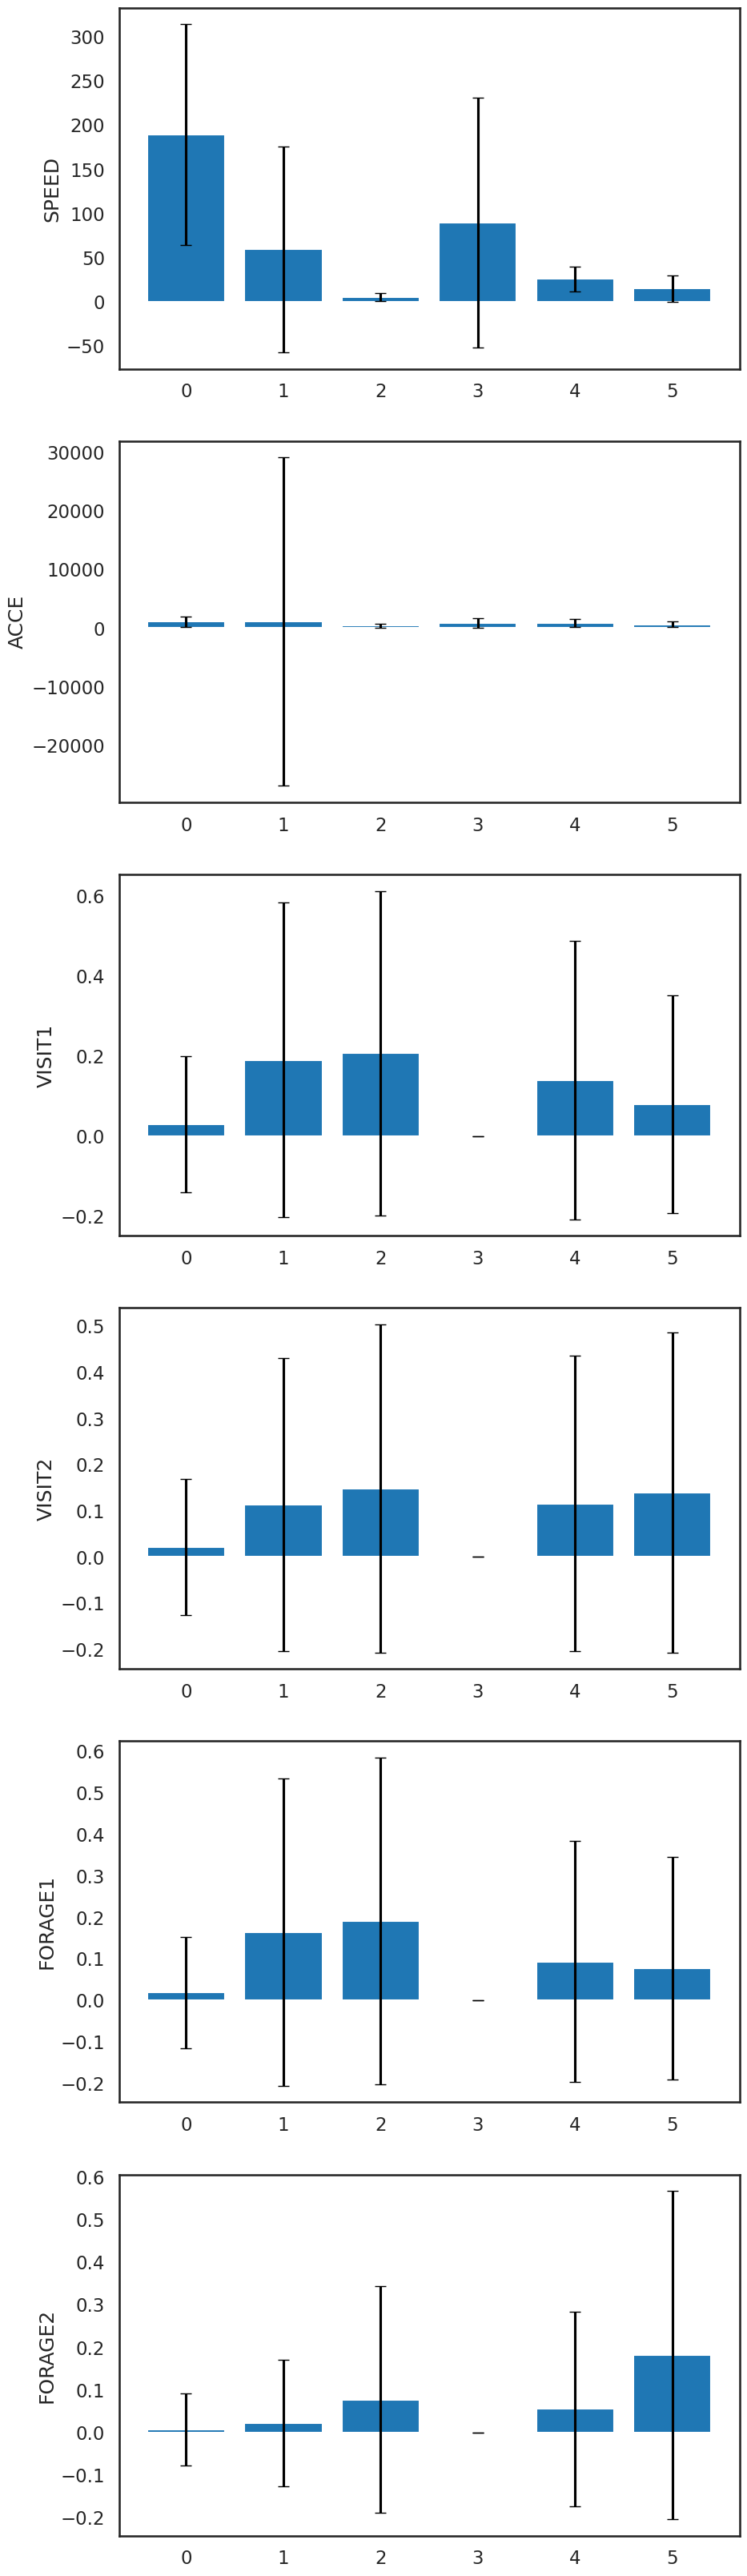

In [15]:
# Position
fig, axs = plt.subplots(1, N, figsize = (N*8-2,6))
for i in range(N):
    heatmap, xedges, yedges = np.histogram2d(X[i], Y[i], bins=30)
    cax = axs[i].imshow(heatmap.T, origin='lower', cmap='binary', interpolation='nearest', aspect='equal')
    axs[i].set_title('State' + str(i))
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
plt.show()

# Speed, Acceleration, Visits in Patch 1, Visits in Patch 2, Forage in Patch 1, Forage in Patch 2
fig, axs = plt.subplots(6, 1, figsize = (10, 6*7-1))
DATA = [SPEED, ACCE, VISIT1, VISIT2, FORAGE1, FORAGE2]
FEATURE = ['SPEED', 'ACCE', 'VISIT1', 'VISIT2', 'FORAGE1', 'FORAGE2']
for data, i in zip(DATA, range(len(DATA))):
    means = [np.mean(arr) for arr in data]
    std_devs = [np.std(arr) for arr in data]
    axs[i].bar(range(N), means, yerr=std_devs, capsize=5)
    axs[i].set_xticks(range(0, 6), ['0', '1', '2', '3', '4', '5'])
    axs[i].set_ylabel(FEATURE[i])
plt.show()

# Long

In [12]:
'''for session, i in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    title = 'LongSession'+str(i)
    print(title)
                    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)
            
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
                
    patch.AddKinematics(title, mouse_pos)
    
    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]
            
    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
    patch.AddWeight(mouse_pos, weight)
            
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
                
    patch.InPatch(mouse_pos, pellets_patch1, pellets_patch2)
        
    mouse_pos.to_parquet(title+'mousepos.parquet', engine='pyarrow')'''

"for session, i in zip(list(long_sessions.itertuples()), range(len(long_sessions))):\n    title = 'LongSession'+str(i)\n    print(title)\n                    \n    start, end = session.enter, session.exit\n    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)\n    mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)\n            \n    start, end = mouse_pos.index[0], mouse_pos.index[-1]\n                \n    patch.AddKinematics(title, mouse_pos)\n    \n    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]\n            \n    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)\n    patch.AddWeight(mouse_pos, weight)\n            \n    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)\n    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)\n                \n    patch.InPatch(mouse_pos, pellets_patch1, pellets_patch2)\n        \n    mouse_pos.to_parquet(title